# ArcGis Esri Converter

## Setup / Imports

In [1]:
# Clone from ArcGisPro -> Arcgis Arcpy Envvironment:
# conda create --name arcgis_arcpy --clone "C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3"

# activate new environment:
# conda activate arcgis_arcpy

# Add new environment to jupyter notebook:
# python -m ipykernel install --user --name arcgis_arcpy --display-name "ArcGIS-ArcPy"

# Select kernel for using this notebook: ArcGIS-ArcPy

In [1]:
import arcpy
from arcpy.sa import *
print(arcpy.GetInstallInfo()["InstallType"])

N/A


In [55]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import glob
import re
from pathlib import Path
from datetime import datetime, timedelta
from typing import Dict, List, Tuple, Optional
import unicodedata

In [56]:
#%%capture
#!pip install mikeio

In [57]:
import mikeio
from mikeio import Grid2D, DataArray, Dataset, Dfs2
from mikeio import ItemInfo, EUMType, EUMUnit

In [58]:
print(mikeio.__version__)

1.7.1


## 1. Define Paths & Environment

In [59]:
# ==== 1. SET UP PATHS ====
# Get current working directory
current_dir = os.getcwd()

# Go up one level to the parent directory
parent_dir = os.path.dirname(current_dir)

# Source folder for .asc and .vel input files
source_folder = Path(parent_dir) / "windninja" / "windninja_output"

# Destination folder for lv95 tif output from ArcGis
destination_folder_tif = os.path.join(parent_dir, r"MIKE21\wind_tif_lv95")
os.makedirs(destination_folder_tif, exist_ok=True)

# Destination folder for lv95 ASCII output from ArcGis
destination_folder_asc = os.path.join(parent_dir, r"MIKE21\wind_asc_lv95")
os.makedirs(destination_folder_asc, exist_ok=True)

# Destination folder for DFS2 output
destination_folder_dfs2 = os.path.join(parent_dir, r"MIKE21\wind_dfs2")
os.makedirs(destination_folder_dfs2, exist_ok=True)

# Geodatabase to hold intermediates
gdb_path = os.path.join(parent_dir, r"MIKE21\wind_arcgis_gdb\wind.gdb")
os.makedirs(os.path.dirname(gdb_path), exist_ok=True)
if not arcpy.Exists(gdb_path):
    arcpy.management.CreateFileGDB(os.path.dirname(gdb_path), Path(gdb_path).name, "CURRENT")


In [60]:
base_root = Path(source_folder)
if not base_root.exists():
    raise FileNotFoundError(f"Source root not found: {base_root}")

In [61]:
# ---- ArcGIS env ----
arcpy.CheckOutExtension("Spatial")
arcpy.env.overwriteOutput = True
arcpy.env.workspace = gdb_path

## PROCESS LOOP: CONVERT WINDFILES from ASCII to DFS2 GRID - FOR MULTIPLE TIME STEPS

In [87]:
# --- USER SETTINGS ---------------------------------------------------
START = "2025-08-24 02:00"
END   = "2025-08-24 23:50"
STEP_MIN = 10  # interval between timesteps

# --- BUILD 10-MINUTE TIMESTEPS --------------------------------------
start_dt_global = datetime.strptime(START, "%Y-%m-%d %H:%M")
end_dt_global   = datetime.strptime(END, "%Y-%m-%d %H:%M")

times = []
t = start_dt_global
while t <= end_dt_global:
    times.append(t)
    t += timedelta(minutes=STEP_MIN)

print(f"Processing {len(times)} timesteps from {START} to {END}")

Processing 132 timesteps from 2025-08-24 02:00 to 2025-08-24 23:50


In [88]:
FOLDER_PREFIX = "Output_"
FOLDER_SUFFIX = "_Google earth_Fire_150m_10min"

# --- Source/Target CRS ---
SRC_SRS  = arcpy.SpatialReference(32632)  # WGS 84 / UTM zone 32N
DEST_SRS = arcpy.SpatialReference(2056)   # CH1903+ / LV95 
CELL_SIZE = 25.0

# Use the composite transform string your install listed:
GT = '~ETRS_1989_To_WGS_1984 + ~"CH1903+_To_ETRS_1989_1"'


In [89]:
# Big Loop with all the process steps

def process_one_timestep(when_dt, overwrite=True):
    
    """
    Run full pipeline for a single timestep (10-min).
    Returns (u_asc_path, v_asc_path, when_dt) or None if missing inputs.
    Skips work if outputs already exist unless overwrite=True.
    """
    # ---- Names from 'when_dt'
    stamp_hy = when_dt.strftime("%Y%m%d-%H%M")     # e.g. 20250831-0810
    stamp    = when_dt.strftime("%Y%m%d_%H%M")     # e.g. 20250831_0810
    date_str = when_dt.strftime("%Y-%m-%d")
    mmddyyyy = when_dt.strftime("%m-%d-%Y")
    hhmm     = when_dt.strftime("%H%M")
    hh       = when_dt.strftime("%H")

    # Find the single (or first) folder whose window contains the chosen HHMM
    #---------------------------------------------------------------------------
    
    candidate_folders = [
        f for f in base_root.iterdir()
        if f.is_dir()
        and f.name.startswith(f"{FOLDER_PREFIX}{date_str}_{hh}")]
    
    if not candidate_folders:
        raise FileNotFoundError(f"No Output_ folder for {date_str} containing time {hhmm} found under {base_root}")
    else:
        # If multiple match, pick the most recently modified (you can change this rule)
        folder = max(candidate_folders, key=lambda p: p.stat().st_mtime)
    
        pattern_ang = f"merlingen_7.5mi_point_{mmddyyyy}_{hhmm}_150m_ang.asc" 
        pattern_vel = f"merlingen_7.5mi_point_{mmddyyyy}_{hhmm}_150m_vel.asc"
    
        ang_path = folder / pattern_ang
        vel_path = folder / pattern_vel
    
        # Check if files exist directly
        ang_exists = ang_path.exists()
        vel_exists = vel_path.exists()
    
        if ang_exists and vel_exists:
            
            print("\n✅ ang.asc and vel.asc files seleceted:")
            print("   Selected time step:", str(when_dt))
            print("   Folder:", folder.name)
            print("   ANG:", ang_path.name)
            print("   VEL:", vel_path.name)
            
        else:
            print( "Error files not found")
            return None

    # Calculate U and V velocity components
    #-----------------------------------------------------------------------------
    
    # Build output names ---
    stamp = when_dt.strftime("%Y%m%d-%H%M")              
    name_u = f"WGS_U_{stamp}"
    name_v = f"WGS_V_{stamp}"
    
    # File geodatabases are picky about characters; use underscores inside the GDB
    safe_u = name_u.replace("-", "_")
    safe_v = name_v.replace("-", "_")
    
    # Import ASCII to rasters in GDB
    vel_r = arcpy.conversion.ASCIIToRaster(str(vel_path), f"vel_{stamp.replace('-', '_')}", "FLOAT")
    ang_r = arcpy.conversion.ASCIIToRaster(str(ang_path), f"ang_{stamp.replace('-', '_')}", "FLOAT")
    
    # Compute U and V with map algebra (radians)
    U = -Raster(vel_r) * Sin(Raster(ang_r) * math.pi / 180.0)
    V = -Raster(vel_r) * Cos(Raster(ang_r) * math.pi / 180.0)

    # Save to geodatabase
    U.save(safe_u)
    V.save(safe_v)

    print("✅ U and V Rasters saved to geodatabase:")
    print("   U:", os.path.join(gdb_path, safe_u), f"(label: {name_u})")
    print("   V:", os.path.join(gdb_path, safe_v), f"(label: {name_v})")

    # Project Velocity components to LV95 Coordinate System
    #-------------------------------------------------------------------------------------

    # Inputs in the GDB (created in previous step)
    u_in = os.path.join(gdb_path, safe_u)      
    v_in = os.path.join(gdb_path, safe_v)
    
    # Outputs (GeoTIFF)
    u_out = os.path.join(destination_folder_tif, f"wind_U_lv95_{stamp}.tif")
    v_out = os.path.join(destination_folder_tif, f"wind_V_lv95_{stamp}.tif")

    # Define (tag) the correct source CRS (no reprojection)
    arcpy.env.overwriteOutput = True
    arcpy.management.DefineProjection(u_in, SRC_SRS)
    arcpy.management.DefineProjection(v_in, SRC_SRS)

    # Project to LV95 with Nearest + cell size and the composite geographic transform
    
    print("✅ Using geographic transformation:", GT)
    
    arcpy.management.ProjectRaster(
        in_raster=u_in,
        out_raster=u_out,
        out_coor_system=DEST_SRS,
        resampling_type="NEAREST",
        cell_size=CELL_SIZE,
        geographic_transform=GT
    )
    
    arcpy.management.ProjectRaster(
        in_raster=v_in,
        out_raster=v_out,
        out_coor_system=DEST_SRS,
        resampling_type="NEAREST",
        cell_size=CELL_SIZE,
        geographic_transform=GT
    )
    
    print("✅ LV95 GeoTIFFs written:")
    print("  ", u_out)
    print("  ", v_out)

    # Raster to ASCII file
    #---------------------------------------------------------------------------------------
    u_asc = os.path.join(destination_folder_asc, f"wind_U_lv95_{stamp}.asc")
    v_asc = os.path.join(destination_folder_asc, f"wind_V_lv95_{stamp}.asc")
    
    arcpy.env.overwriteOutput = True
    arcpy.conversion.RasterToASCII(u_out, u_asc)  # u_out from previous step (LV95 GeoTIFF)
    arcpy.conversion.RasterToASCII(v_out, v_asc)
    
    print("✅ ASCII written:")
    print("  ", u_asc)
    print("  ", v_asc)

    # Build DFS2 windfield file with Mikeio
    #----------------------------------------------------------------------------------------
    
    LV95_WKT = arcpy.Describe(u_out).spatialReference.exportToString() 
    dfs2_path = os.path.join(destination_folder_dfs2, f"wind_uv_{stamp}.dfs2")
    
    dfs2_from_uv_ascii(
        u_path=u_asc,
        v_path=v_asc,
        when=pd.to_datetime(start_dt_global),
        out_path=dfs2_path,
        projection_wkt=LV95_WKT
    )

    print("✅ DFS2 written:", dfs2_path)
    
    return (u_asc, v_asc, when_dt)


In [90]:
# 1. Helper function Mikeio conversion

def read_esri_ascii(path: str):
    """
    Parse ESRI ASCII raster -> (data2d, ncols, nrows, xllcorner, yllcorner, cellsize, nodata)
    Data is returned as [nrows, ncols] float32 with NODATA set to np.nan
    """
    hdr = {}
    with open(path, "r", encoding="utf-8") as f:
        for _ in range(6):
            k, v = f.readline().strip().split()
            hdr[k.upper()] = float(v)
    ncols = int(hdr["NCOLS"]); nrows = int(hdr["NROWS"])
    xll  = hdr["XLLCORNER"];   yll  = hdr["YLLCORNER"]
    cs   = hdr["CELLSIZE"];    ndv  = hdr.get("NODATA_VALUE", -9999.0)

    # Remaining lines are the data in row-major (top row first)
    arr = np.loadtxt(path, skiprows=6)
    arr = arr.reshape(nrows, ncols).astype("float32")
    arr[arr == ndv] = np.nan
    return arr, ncols, nrows, xll, yll, cs

In [91]:
# 2. Helper function Mikeio conversion

def dfs2_from_uv_ascii(u_path: str, v_path: str, when: pd.Timestamp, out_path: str, projection_wkt: str):
    u, nx, ny, xll, yll, cs  = read_esri_ascii(u_path)
    v, nx2, ny2, xll2, yll2, cs2 = read_esri_ascii(v_path)
    assert (nx, ny, cs, xll, yll) == (nx2, ny2, cs2, xll2, yll2), "U/V grids mismatch"

    # ASCII origin is lower-left corner; mikeio uses lower-left **center**
    x0 = xll + cs/2.0
    y0 = yll + cs/2.0

    # Flip so first row is south-most (mikeio expects south->north)
    u_south_up = np.flipud(u)
    v_south_up = np.flipud(v)

    g = Grid2D(dx=cs, dy=cs, nx=nx, ny=ny, x0=x0, y0=y0, projection=projection_wkt)  # pass WKT here!

    # safe item defs across mikeio versions
    from mikeio import ItemInfo, EUMType, EUMUnit
    try:
        itm_u = ItemInfo("U wind", EUMType.u_velocity_component, EUMUnit.meter_per_sec)
        itm_v = ItemInfo("V wind", EUMType.v_velocity_component, EUMUnit.meter_per_sec)
    except AttributeError:
        itm_u = ItemInfo("U wind", EUMType.Velocity, EUMUnit.meter_per_sec)
        itm_v = ItemInfo("V wind", EUMType.Velocity, EUMUnit.meter_per_sec)

    t = pd.DatetimeIndex([when])
    ds = Dataset(
        [
            DataArray(u_south_up[np.newaxis, ...], time=t, item=itm_u, geometry=g),
            DataArray(v_south_up[np.newaxis, ...], time=t, item=itm_v, geometry=g),
        ]
    )
    #Dfs2().write(out_path, ds) - old function phasing out
    ds.to_dfs(out_path) #--new function
    return out_path

In [92]:
# function for using multiple timestep dfs2 files

def dfs2_from_uv_ascii_series(u_paths, v_paths, times, out_path, projection_wkt):
    """Merge multiple (U,V) ASCII rasters into one multi-time DFS2."""
    assert len(u_paths) == len(v_paths) == len(times), "Mismatch in list lengths"

    # --- read first grid to define geometry
    u0, nx, ny, xll, yll, cs = read_esri_ascii(u_paths[0])
    x0 = xll + cs/2.0; y0 = yll + cs/2.0
    g = Grid2D(dx=cs, dy=cs, nx=nx, ny=ny, x0=x0, y0=y0, projection=projection_wkt)

    try:
        itm_u = ItemInfo("U wind", EUMType.u_velocity_component, EUMUnit.meter_per_sec)
        itm_v = ItemInfo("V wind", EUMType.v_velocity_component, EUMUnit.meter_per_sec)
    except AttributeError:
        itm_u = ItemInfo("U wind", EUMType.Velocity, EUMUnit.meter_per_sec)
        itm_v = ItemInfo("V wind", EUMType.Velocity, EUMUnit.meter_per_sec)

    # --- stack all timesteps
    data_u, data_v = [], []
    for up, vp in zip(u_paths, v_paths):
        u, nx2, ny2, *_ = read_esri_ascii(up)
        v, *_ = read_esri_ascii(vp)
        assert (nx2 == nx) and (ny2 == ny), "Grid size mismatch"
        data_u.append(np.flipud(u))
        data_v.append(np.flipud(v))

    data_u = np.stack(data_u)  # shape (nt, ny, nx)
    data_v = np.stack(data_v)
    t = pd.DatetimeIndex(times)

    ds = Dataset(
        [
            DataArray(data_u, time=t, item=itm_u, geometry=g),
            DataArray(data_v, time=t, item=itm_v, geometry=g),
        ]
    )

    ds.to_dfs(out_path)  # modern writer, no warning
    print(f"✅ DFS2 written with {len(times)} timesteps → {out_path}")
    return out_path

In [93]:
# Executing LOOP over ALL ABOVE timesteps with the above code

u_list, v_list, t_list = [], [], []

for when_dt in times:
    print(f"\n============================ Processing timestep {when_dt} ========================================")
    res = process_one_timestep(when_dt, overwrite=True)
    if res is None:
        continue
    u_asc, v_asc, when = res
    u_list.append(u_asc)
    v_list.append(v_asc)
    t_list.append(when)

# Write ONE multi-time dfs2 if we have any slices
if t_list:
    LV95_WKT = arcpy.SpatialReference(2056).exportToString()
    # Name the file from first/last time
    t0 = min(t_list).strftime("%Y%m%d_%H%M")
    t1 = max(t_list).strftime("%Y%m%d_%H%M")
    out_multi = os.path.join(destination_folder_dfs2, f"wind_uv_{t0}_{t1}.dfs2")

    dfs2_from_uv_ascii_series(
        u_paths=u_list,
        v_paths=v_list,
        times=sorted(t_list),
        out_path=out_multi,
        projection_wkt=LV95_WKT
    )
else:
    print("No complete timesteps found → nothing to write as multi-time DFS2.")

    


============================ Processing timestep 2025-08-24 02:00:00 ========================================

✅ ang.asc and vel.asc files seleceted:
   Selected time step: 2025-08-24 02:00:00
   Folder: Output_2025-08-24_0200-0250_Google earth_Fire_150m_10min
   ANG: merlingen_7.5mi_point_08-24-2025_0200_150m_ang.asc
   VEL: merlingen_7.5mi_point_08-24-2025_0200_150m_vel.asc
✅ U and V Rasters saved to geodatabase:
   U: c:\users\a\documents\xx_github_repo\data-waves\MIKE21\wind_arcgis_gdb\wind.gdb\WGS_U_20250824_0200 (label: WGS_U_20250824-0200)
   V: c:\users\a\documents\xx_github_repo\data-waves\MIKE21\wind_arcgis_gdb\wind.gdb\WGS_V_20250824_0200 (label: WGS_V_20250824-0200)
✅ Using geographic transformation: ~ETRS_1989_To_WGS_1984 + ~"CH1903+_To_ETRS_1989_1"
✅ LV95 GeoTIFFs written:
   c:\users\a\documents\xx_github_repo\data-waves\MIKE21\wind_tif_lv95\wind_U_lv95_20250824-0200.tif
   c:\users\a\documents\xx_github_repo\data-waves\MIKE21\wind_tif_lv95\wind_V_lv95_20250824-0200.tif

# PROCESS LOOP: CONVERT WIND SPEED and DIRECTION from ASCII to DFS2 GRID - FOR MULTIPLE TIME STEPS , LV95

In [94]:
# --- USER SETTINGS ---------------------------------------------------
START = "2025-08-24 02:00"
END   = "2025-08-24 23:50"
STEP_MIN = 10  # interval between timesteps

# --- BUILD 10-MINUTE TIMESTEPS --------------------------------------
start_dt_global = datetime.strptime(START, "%Y-%m-%d %H:%M")
end_dt_global   = datetime.strptime(END, "%Y-%m-%d %H:%M")

times = []
t = start_dt_global
while t <= end_dt_global:
    times.append(t)
    t += timedelta(minutes=STEP_MIN)

print(f"Processing {len(times)} timesteps from {START} to {END}")

Processing 132 timesteps from 2025-08-24 02:00 to 2025-08-24 23:50


In [95]:
FOLDER_PREFIX = "Output_"
FOLDER_SUFFIX = "_Google earth_Fire_150m_10min"

# --- Source/Target CRS ---
SRC_SRS  = arcpy.SpatialReference(32632)  # WGS 84 / UTM zone 32N
DEST_SRS = arcpy.SpatialReference(2056)   # CH1903+ / LV95 
CELL_SIZE = 25.0

# Use the composite transform string your install listed:
GT = '~ETRS_1989_To_WGS_1984 + ~"CH1903+_To_ETRS_1989_1"'


In [96]:
# Big Loop with all the process steps

def process_one_timestep_speed_dir(when_dt, overwrite=True):
    
    """
    Run full pipeline for a single timestep (10-min).
    Returns (u_asc_path, v_asc_path, when_dt) or None if missing inputs.
    Skips work if outputs already exist unless overwrite=True.
    """
    # ---- Names from 'when_dt'
    stamp_hy = when_dt.strftime("%Y%m%d-%H%M")     # e.g. 20250831-0810
    stamp    = when_dt.strftime("%Y%m%d_%H%M")     # e.g. 20250831_0810
    date_str = when_dt.strftime("%Y-%m-%d")
    mmddyyyy = when_dt.strftime("%m-%d-%Y")
    hhmm     = when_dt.strftime("%H%M")
    hh       = when_dt.strftime("%H")

    # Find the single (or first) folder whose window contains the chosen HHMM
    #---------------------------------------------------------------------------
    
    candidate_folders = [
        f for f in base_root.iterdir()
        if f.is_dir()
        and f.name.startswith(f"{FOLDER_PREFIX}{date_str}_{hh}")]
    
    if not candidate_folders:
        raise FileNotFoundError(f"No Output_ folder for {date_str} containing time {hhmm} found under {base_root}")
    else:
        # If multiple match, pick the most recently modified (you can change this rule)
        folder = max(candidate_folders, key=lambda p: p.stat().st_mtime)
    
        pattern_ang = f"merlingen_7.5mi_point_{mmddyyyy}_{hhmm}_150m_ang.asc" 
        pattern_vel = f"merlingen_7.5mi_point_{mmddyyyy}_{hhmm}_150m_vel.asc"
    
        ang_path = folder / pattern_ang
        vel_path = folder / pattern_vel
    
        # Check if files exist directly
        ang_exists = ang_path.exists()
        vel_exists = vel_path.exists()
    
        if ang_exists and vel_exists:
            
            print("\n✅ ang.asc and vel.asc files seleceted:")
            print("   Selected time step:", str(when_dt))
            print("   Folder:", folder.name)
            print("   ANG:", ang_path.name)
            print("   VEL:", vel_path.name)
            
        else:
            print( "Error files not found")
            return None

    # Targets
    #-----------------------------------------------------------------------------
    
    ang_tif = os.path.join(destination_folder_tif, f"wind_DIR_lv95_{stamp}.tif")
    vel_tif = os.path.join(destination_folder_tif, f"wind_SPD_lv95_{stamp}.tif")
    dir_asc = os.path.join(destination_folder_asc, f"wind_DIR_lv95_{stamp}.asc")
    spd_asc = os.path.join(destination_folder_asc, f"wind_SPD_lv95_{stamp}.asc")

    # Skip if ASCII already exist
    if (not overwrite) and os.path.exists(dir_asc) and os.path.exists(spd_asc):
        print("⏩ Skipping compute: final ASCII already exist.")
        return (spd_asc, dir_asc, when_dt)

    arcpy.env.overwriteOutput = overwrite
    
    # Import ASCII to rasters in GDB
    vel_r = arcpy.conversion.ASCIIToRaster(str(vel_path), f"vel_{stamp.replace('-', '_')}", "FLOAT")
    ang_r = arcpy.conversion.ASCIIToRaster(str(ang_path), f"ang_{stamp.replace('-', '_')}", "FLOAT")
    
    # Project components to LV95 Coordinate System
    #-------------------------------------------------------------------------------------

    for r in (ang_r, vel_r):
        d = arcpy.Describe(r)
        sr = getattr(d, "spatialReference", None)
        if (sr is None) or (sr.factoryCode in (0, None)) or (sr.name in ("Unknown", "Undefined")):
            arcpy.management.DefineProjection(r, SRC_SRS)

    # --- 3) Project ANG & VEL to LV95 (NEAREST)
    if overwrite or (not os.path.exists(ang_tif) or not os.path.exists(vel_tif)):
        arcpy.management.ProjectRaster(ang_r, ang_tif, DEST_SRS, "NEAREST", CELL_SIZE, GT)
        arcpy.management.ProjectRaster(vel_r, vel_tif, DEST_SRS, "NEAREST", CELL_SIZE, GT)
        print("✅ Projected ANG/VEL to LV95 TIF")
    else:
        print("⏩ Skipping ProjectRaster: LV95 TIFs already exist")

    # --- 4) RasterToASCII
    if overwrite or (not os.path.exists(dir_asc) or not os.path.exists(spd_asc)):
        arcpy.conversion.RasterToASCII(ang_tif, dir_asc)
        arcpy.conversion.RasterToASCII(vel_tif, spd_asc)
        print("✅ ASCII written:", os.path.basename(spd_asc), os.path.basename(dir_asc))
    else:
        print("⏩ Skipping RasterToASCII: ASCII already exist")

    # --- 5) (Optional) per-timestep DFS2 with 2 items (speed+direction)
    LV95_WKT = arcpy.Describe(ang_tif).spatialReference.exportToString()
    single_dfs2 = os.path.join(destination_folder_dfs2, f"wind_sd_{stamp}.dfs2")
    if overwrite or (not os.path.exists(single_dfs2)):
        dfs2_from_speed_dir_ascii(spd_asc, dir_asc, when_dt, single_dfs2, LV95_WKT)
        print("✅ single-step DFS2:", single_dfs2)
    else:
        print("⏩ Skipping per-step DFS2 (exists)")

    return (spd_asc, dir_asc, when_dt)

In [97]:
def dfs2_from_speed_dir_ascii(speed_path: str, dir_path: str, when: pd.Timestamp, out_path: str, projection_wkt: str):
    spd, nx, ny, xll, yll, cs   = read_esri_ascii(speed_path)
    drc, nx2, ny2, xll2, yll2, cs2 = read_esri_ascii(dir_path)
    assert (nx, ny, cs, xll, yll) == (nx2, ny2, cs2, xll2, yll2), "Speed/Direction grids mismatch"

    # ESRI ASCII origin is lower-left CORNER; mikeio uses lower-left CENTER
    x0 = xll + cs/2.0
    y0 = yll + cs/2.0

    # Flip so first row is south-most (mikeio expects south->north)
    spd_south = np.flipud(spd)
    drc_south = np.flipud(drc)

    # Optional: ensure direction in [0,360)
    drc_south = np.mod(drc_south, 360.0)

    g = Grid2D(dx=cs, dy=cs, nx=nx, ny=ny, x0=x0, y0=y0, projection=projection_wkt)

    # EUM items with safe fallbacks across mikeio versions
    try:
        itm_spd = ItemInfo("Wind speed", EUMType.Wind_speed, EUMUnit.meter_per_sec)
    except AttributeError:
        itm_spd = ItemInfo("Wind speed", EUMType.Speed, EUMUnit.meter_per_sec)
    try:
        itm_dir = ItemInfo("Wind direction", EUMType.Wind_direction, EUMUnit.degree)
    except AttributeError:
        itm_dir = ItemInfo("Wind direction", EUMType.Direction, EUMUnit.degree)

    t = pd.DatetimeIndex([when])
    ds = Dataset(
        [
            DataArray(spd_south[np.newaxis, ...], time=t, item=itm_spd, geometry=g),
            DataArray(drc_south[np.newaxis, ...], time=t, item=itm_dir, geometry=g),
        ]
    )
    ds.to_dfs(out_path)
    return out_path

In [98]:
# --- Multiple timesteps: SPEED + DIRECTION -> one multi-time dfs2 ----
def dfs2_from_speed_dir_ascii_series(speed_paths, dir_paths, times, out_path, projection_wkt):
    """Merge multiple (speed, direction) ASCII rasters into one multi-time DFS2."""
    assert len(speed_paths) == len(dir_paths) == len(times), "Mismatch in list lengths"

    # Define geometry from first grid
    spd0, nx, ny, xll, yll, cs = read_esri_ascii(speed_paths[0])
    x0 = xll + cs/2.0
    y0 = yll + cs/2.0
    g = Grid2D(dx=cs, dy=cs, nx=nx, ny=ny, x0=x0, y0=y0, projection=projection_wkt)

    # Prepare items (with fallbacks)
    try:
        itm_spd = ItemInfo("Wind speed", EUMType.Wind_speed, EUMUnit.meter_per_sec)
    except AttributeError:
        itm_spd = ItemInfo("Wind speed", EUMType.Speed, EUMUnit.meter_per_sec)
    try:
        itm_dir = ItemInfo("Wind direction", EUMType.Wind_direction, EUMUnit.degree)
    except AttributeError:
        itm_dir = ItemInfo("Wind direction", EUMType.Direction, EUMUnit.degree)

    # Stack all timesteps
    data_spd, data_dir = [], []
    for sp, dp in zip(speed_paths, dir_paths):
        s, nx2, ny2, *_ = read_esri_ascii(sp)
        d, *_ = read_esri_ascii(dp)
        assert (nx2 == nx) and (ny2 == ny), "Grid size mismatch"
        data_spd.append(np.flipud(s))
        data_dir.append(np.mod(np.flipud(d), 360.0))  # normalize to [0,360)

    data_spd = np.stack(data_spd)  # (nt, ny, nx)
    data_dir = np.stack(data_dir)
    t = pd.DatetimeIndex(times)

    ds = Dataset(
        [
            DataArray(data_spd, time=t, item=itm_spd, geometry=g),
            DataArray(data_dir, time=t, item=itm_dir, geometry=g),
        ]
    )
    ds.to_dfs(out_path)
    print(f"✅ DFS2 written with {len(times)} timesteps → {out_path}")
    return out_path

In [99]:
spd_list, dir_list, t_list = [], [], []

for when_dt in times:
    print(f"\n=== Processing {when_dt:%Y-%m-%d %H:%M} ===")
    res = process_one_timestep_speed_dir(when_dt, overwrite=True)
    if res is None:
        continue
    spd_asc, dir_asc, when = res
    spd_list.append(spd_asc)
    dir_list.append(dir_asc)
    t_list.append(when)

# One multi-time DFS2 with all 10-min steps
if t_list:
    LV95_WKT = arcpy.SpatialReference(2056).exportToString()
    t0 = min(t_list).strftime("%Y%m%d_%H%M")
    t1 = max(t_list).strftime("%Y%m%d_%H%M")
    final_dfs2 = os.path.join(destination_folder_dfs2, f"wind_sd_{t0}_{t1}.dfs2")
    dfs2_from_speed_dir_ascii_series(spd_list, dir_list, sorted(t_list), final_dfs2, LV95_WKT)
else:
    print("No complete timesteps → nothing to write.")


=== Processing 2025-08-24 02:00 ===

✅ ang.asc and vel.asc files seleceted:
   Selected time step: 2025-08-24 02:00:00
   Folder: Output_2025-08-24_0200-0250_Google earth_Fire_150m_10min
   ANG: merlingen_7.5mi_point_08-24-2025_0200_150m_ang.asc
   VEL: merlingen_7.5mi_point_08-24-2025_0200_150m_vel.asc
✅ Projected ANG/VEL to LV95 TIF
✅ ASCII written: wind_SPD_lv95_20250824_0200.asc wind_DIR_lv95_20250824_0200.asc
✅ single-step DFS2: c:\users\a\documents\xx_github_repo\data-waves\MIKE21\wind_dfs2\wind_sd_20250824_0200.dfs2

=== Processing 2025-08-24 02:10 ===

✅ ang.asc and vel.asc files seleceted:
   Selected time step: 2025-08-24 02:10:00
   Folder: Output_2025-08-24_0200-0250_Google earth_Fire_150m_10min
   ANG: merlingen_7.5mi_point_08-24-2025_0210_150m_ang.asc
   VEL: merlingen_7.5mi_point_08-24-2025_0210_150m_vel.asc
✅ Projected ANG/VEL to LV95 TIF
✅ ASCII written: wind_SPD_lv95_20250824_0210.asc wind_DIR_lv95_20250824_0210.asc
✅ single-step DFS2: c:\users\a\documents\xx_github_

# COMPARE three DFS2 files
(UV components with different directions / speed and direction from same timestamp)

In [46]:
# Input files
# -------------------------------------------------------------------

file_ref_name = r"wind_uv_20251023-0200.dfs2"          # reference (assumed correct)
file_test_name = r"wind_uv_20251023-0200_false_dir.dfs2"  # file to compare
file_sd_name = r"wind_sd_20251023_0200.dfs2"

file_ref = os.path.join(destination_folder_dfs2, file_ref_name)
file_test = os.path.join(destination_folder_dfs2, file_test_name)
file_sd = os.path.join(destination_folder_dfs2, file_sd_name)


In [47]:
# 2. HELPER FUNCTIONS
# -------------------------------------------------------------------
def cartesian_speed_dir(u, v):
    """
    Compute wind speed and direction (towards) from U,V components.

    Direction convention (mathematical):
        dir_math [deg] measured counter-clockwise from +x (east),
        with 0° = east, 90° = north, 180° = west, 270° = south.

    This is the natural convention for vectors defined by (u,v).
    """
    speed = np.sqrt(u**2 + v**2)
    dir_rad = np.arctan2(v, u)  # atan2(y, x) = atan2(v, u)
    dir_deg = np.degrees(dir_rad) % 360.0
    return speed, dir_deg

def met_speed_dir_to_uv(speed, direction_deg):
    """
    Convert meteorological wind direction (FROM which wind blows, deg)
    and speed (m/s) to Cartesian U,V components (TOWARDS where wind blows).

    Meteorological convention:
        direction_deg:
            0°   = from north (blowing south)
            90°  = from east  (blowing west)
            180° = from south (blowing north)
            270° = from west  (blowing east)

    Output:
        U > 0  → flow towards east
        V > 0  → flow towards north
    """
    theta_rad = np.deg2rad(direction_deg)
    u = -speed * np.sin(theta_rad)
    v = -speed * np.cos(theta_rad)
    return u, v


def angle_diff_deg(a, b):
    """
    Smallest signed angular difference between angles a and b (deg).

    Returns values in [-180, 180], where positive means b is rotated
    counter-clockwise relative to a.
    """
    d = (b - a + 180.0) % 360.0 - 180.0
    return d


def math_towards_to_met_from(dir_math_deg):
    """
    Convert a 'mathematical' direction (towards, CCW from +x/east)
    to a 'meteorological FROM' direction (clockwise from north).

    Given:
        dir_math_deg: 0°=east, 90°=north, 180°=west, 270°=south (towards)

    Steps:
        1) Convert to 'towards, clockwise from north':
               beta_towards = (90 - dir_math_deg) % 360
        2) Convert towards -> from:
               alpha_from   = (beta_towards + 180) % 360

    Result:
        alpha_from: meteorological 'from' direction
                    0°=from north, 90°=from east, etc.
    """
    beta_towards = (90.0 - dir_math_deg) % 360.0
    alpha_from = (beta_towards + 180.0) % 360.0
    return alpha_from



In [48]:
# 3. READ DFS2 FILES
# -------------------------------------------------------------------
ds_sd   = mikeio.read(file_sd)
ds_ref  = mikeio.read(file_ref)
ds_test = mikeio.read(file_test)

print("SD (speed+dir):\n", ds_sd)
print("REF (U,V):\n", ds_ref)
print("TEST (U,V):\n", ds_test)

# Basic checks
for ds, name in [(ds_sd, "SD"), (ds_ref, "REF"), (ds_test, "TEST")]:
    if len(ds.time) != 1:
        raise ValueError(f"{name} must have exactly 1 timestep, found {len(ds.time)}")

if not (ds_sd.geometry == ds_ref.geometry == ds_test.geometry):
    raise ValueError("Geometries of SD, REF, and TEST do not match.")

g = ds_ref.geometry
x = g.x
y = g.y



SD (speed+dir):
 <mikeio.Dataset>
dims: (time:1, y:997, x:968)
time: 2025-10-23 02:00:00 (time-invariant)
geometry: Grid2D (ny=997, nx=968)
items:
  0:  Wind speed <Wind speed> (meter per sec)
  1:  Wind direction <Direction> (degree)
REF (U,V):
 <mikeio.Dataset>
dims: (time:1, y:997, x:968)
time: 2025-10-23 02:00:00 (time-invariant)
geometry: Grid2D (ny=997, nx=968)
items:
  0:  U wind <u velocity component> (meter per sec)
  1:  V wind <v velocity component> (meter per sec)
TEST (U,V):
 <mikeio.Dataset>
dims: (time:1, y:997, x:968)
time: 2025-10-30 18:00:00 (time-invariant)
geometry: Grid2D (ny=997, nx=968)
items:
  0:  U wind <u velocity component> (meter per sec)
  1:  V wind <v velocity component> (meter per sec)


In [49]:
# 4. EXTRACT FIELDS
# -------------------------------------------------------------------
# SD: assume item0 = speed, item1 = direction (meteorological FROM)
spd_sd = ds_sd[0].values[0, :, :]
dir_sd_met = ds_sd[1].values[0, :, :]

# REF: U,V
u_ref = ds_ref[0].values[0, :, :]
v_ref = ds_ref[1].values[0, :, :]

# TEST: U,V
u_test = ds_test[0].values[0, :, :]
v_test = ds_test[1].values[0, :, :]

In [50]:
# 5. CONVERT REF and TEST U,V -> speed + dir (math, towards)
# -------------------------------------------------------------------
spd_ref_cart, dir_ref_math = cartesian_speed_dir(u_ref, v_ref)
spd_test_cart, dir_test_math = cartesian_speed_dir(u_test, v_test)

# Convert these to meteorological 'from' angles for direct comparison with dir_sd_met
dir_ref_met_from = math_towards_to_met_from(dir_ref_math)
dir_test_met_from = math_towards_to_met_from(dir_test_math)

# Differences vs original SD
dspd_ref_vs_sd  = spd_ref_cart  - spd_sd
dspd_test_vs_sd = spd_test_cart - spd_sd

ddir_ref_vs_sd  = angle_diff_deg(dir_sd_met, dir_ref_met_from)
ddir_test_vs_sd = angle_diff_deg(dir_sd_met, dir_test_met_from)

In [52]:
# 6. OPTIONAL: SD -> U,V (using correct formula) and compare to REF
#     (sanity check: if REF was generated from SD with correct formula,
#      this difference should be ~0)
# -------------------------------------------------------------------
u_sd_expected, v_sd_expected = met_speed_dir_to_uv(spd_sd, dir_sd_met)
du_ref_vs_sd = u_ref - u_sd_expected
dv_ref_vs_sd = v_ref - v_sd_expected

In [53]:
# 7. SUMMARY STATISTICS
# -------------------------------------------------------------------
def print_stats(name, arr):
    arr_valid = arr[~np.isnan(arr)]
    print(f"{name:25s} mean={arr_valid.mean(): .4f}, "
          f"std={arr_valid.std(): .4f}, "
          f"min={arr_valid.min(): .4f}, "
          f"max={arr_valid.max(): .4f}")


print("\n=== REF (U,V) vs SD (speed+dir) ===")
print_stats("ΔSpeed_ref_vs_sd", dspd_ref_vs_sd)
print_stats("ΔDir_ref_vs_sd",   ddir_ref_vs_sd)

print("\n=== TEST (U,V) vs SD (speed+dir) ===")
print_stats("ΔSpeed_test_vs_sd", dspd_test_vs_sd)
print_stats("ΔDir_test_vs_sd",   ddir_test_vs_sd)

print("\n=== REF U,V vs SD→U,V (sanity check) ===")
print_stats("ΔU_ref_vs_sd_expected", du_ref_vs_sd)
print_stats("ΔV_ref_vs_sd_expected", dv_ref_vs_sd)


=== REF (U,V) vs SD (speed+dir) ===
ΔSpeed_ref_vs_sd          mean=-0.0000, std= 0.0000, min=-0.0000, max= 0.0000
ΔDir_ref_vs_sd            mean= 0.0000, std= 0.0000, min=-0.0000, max= 0.0001

=== TEST (U,V) vs SD (speed+dir) ===
ΔSpeed_test_vs_sd         mean=-0.0000, std= 0.0000, min=-0.0000, max= 0.0000
ΔDir_test_vs_sd           mean=-178.5180, std= 23.0503, min=-180.0000, max= 180.0000

=== REF U,V vs SD→U,V (sanity check) ===
ΔU_ref_vs_sd_expected     mean= 0.0000, std= 0.0000, min=-0.0000, max= 0.0000
ΔV_ref_vs_sd_expected     mean= 0.0000, std= 0.0000, min=-0.0000, max= 0.0000


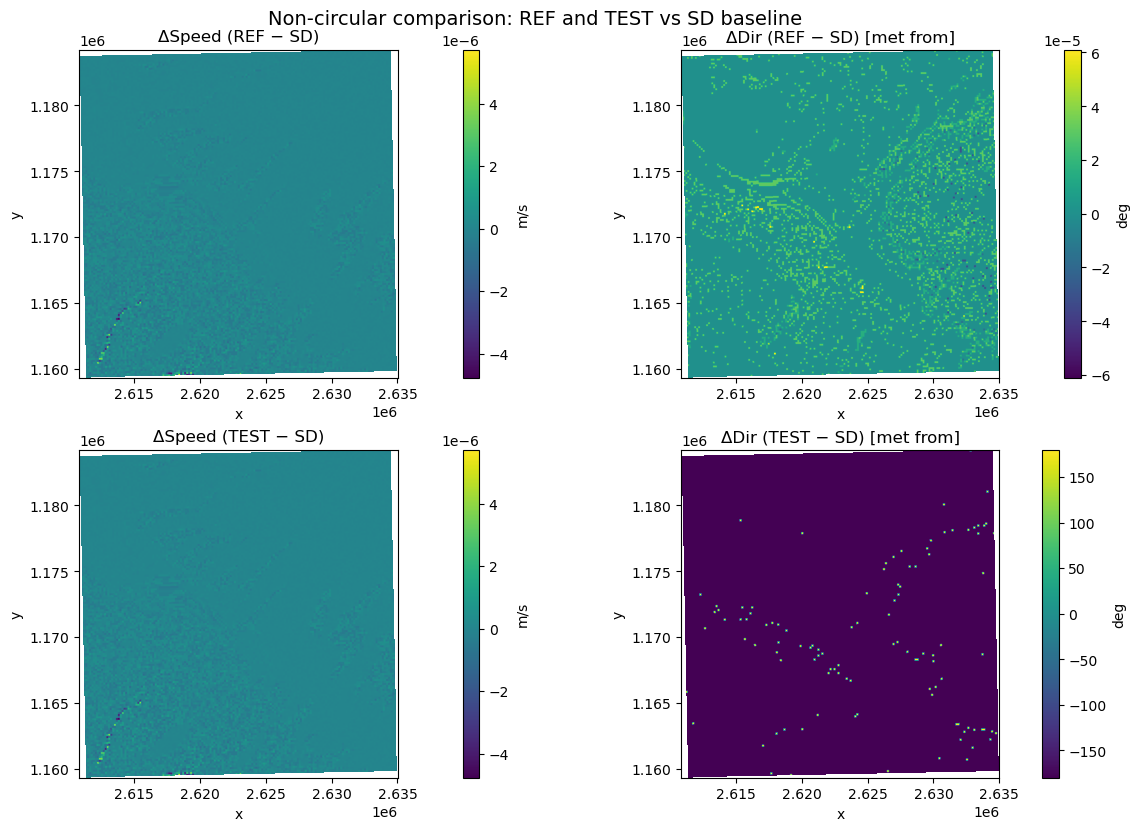

In [54]:
# 8. PLOTTING: maps of differences
# -------------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)

# REF: speed diff
ax = axes[0, 0]
im = ax.imshow(dspd_ref_vs_sd, origin="lower",
               extent=[x[0], x[-1], y[0], y[-1]])
ax.set_title("ΔSpeed (REF − SD)")
ax.set_xlabel("x"); ax.set_ylabel("y")
fig.colorbar(im, ax=ax, label="m/s")

# REF: dir diff
ax = axes[0, 1]
ddir_max_ref = np.nanmax(np.abs(ddir_ref_vs_sd))
im = ax.imshow(ddir_ref_vs_sd, origin="lower",
               extent=[x[0], x[-1], y[0], y[-1]],
               vmin=-ddir_max_ref, vmax=ddir_max_ref)
ax.set_title("ΔDir (REF − SD) [met from]")
ax.set_xlabel("x"); ax.set_ylabel("y")
fig.colorbar(im, ax=ax, label="deg")

# TEST: speed diff
ax = axes[1, 0]
im = ax.imshow(dspd_test_vs_sd, origin="lower",
               extent=[x[0], x[-1], y[0], y[-1]])
ax.set_title("ΔSpeed (TEST − SD)")
ax.set_xlabel("x"); ax.set_ylabel("y")
fig.colorbar(im, ax=ax, label="m/s")

# TEST: dir diff
ax = axes[1, 1]
ddir_max_test = np.nanmax(np.abs(ddir_test_vs_sd))
im = ax.imshow(ddir_test_vs_sd, origin="lower",
               extent=[x[0], x[-1], y[0], y[-1]],
               vmin=-ddir_max_test, vmax=ddir_max_test)
ax.set_title("ΔDir (TEST − SD) [met from]")
ax.set_xlabel("x"); ax.set_ylabel("y")
fig.colorbar(im, ax=ax, label="deg")

fig.suptitle("Non-circular comparison: REF and TEST vs SD baseline", y=1.02, fontsize=14)
plt.show()

## DETAILED PROCESS STEPS FOR ONE TIMESTEP

## 2. Find source files

In [150]:
START = "2025-10-30 18:30"

In [21]:
# Pattern for folders: Output_YYYY-MM-DD_HHMM-HHMM_Google earth_Fire_150m_10min
FOLDER_PREFIX = "Output_"
FOLDER_SUFFIX = "_Google earth_Fire_150m_10min"

start_dt = datetime.strptime(START, "%Y-%m-%d %H:%M")
date_str  = start_dt.strftime("%Y-%m-%d")
ddmmyyyy  = start_dt.strftime("%d-%m-%Y")
mmddyyyy      = start_dt.strftime("%m-%d-%Y")
hhmm      = start_dt.strftime("%H%M")
hh        = start_dt.strftime("%H")


In [22]:
# Find the single (or first) folder whose window contains the chosen HHMM
candidate_folders = [
    f for f in base_root.iterdir()
    if f.is_dir()
    and f.name.startswith(f"{FOLDER_PREFIX}{date_str}_{hh}")]

if not candidate_folders:
    raise FileNotFoundError(f"No Output_ folder for {date_str} containing time {hhmm} found under {base_root}")
else:
    # If multiple match, pick the most recently modified (you can change this rule)
    folder = max(candidate_folders, key=lambda p: p.stat().st_mtime)

    pattern_ang = f"merlingen_7.5mi_point_{mmddyyyy}_{hhmm}_150m_ang.asc" 
    pattern_vel = f"merlingen_7.5mi_point_{mmddyyyy}_{hhmm}_150m_vel.asc"

    ang_path = folder / pattern_ang
    vel_path = folder / pattern_vel

    # Check if files exist directly
    ang_exists = ang_path.exists()
    vel_exists = vel_path.exists()

    if ang_exists and vel_exists == True:
        print("✅ Selected time step:", START)
        print("📂 Folder:", folder.name)
        print("🧭 ANG:", ang_path.name)
        print("💨 VEL:", vel_path.name)
    else:
         print( "Error files not found")


✅ Selected time step: 2025-10-23 02:00
📂 Folder: Output_2025-10-23_0200-0250_Google earth_Fire_150m_10min
🧭 ANG: merlingen_7.5mi_point_10-23-2025_0200_150m_ang.asc
💨 VEL: merlingen_7.5mi_point_10-23-2025_0200_150m_vel.asc


## 3. Calculate U and V Velocity components

In [153]:
# --- Build output names ---
stamp = start_dt.strftime("%Y%m%d-%H%M")              # e.g., 20250831-0810
name_u = f"WGS_U_{stamp}"
name_v = f"WGS_V_{stamp}"


In [154]:
# File geodatabases are picky about characters; use underscores inside the GDB
safe_u = name_u.replace("-", "_")                      # WGS_U_20250831_0810
safe_v = name_v.replace("-", "_")

In [155]:
# --- Import ASCII to rasters in GDB ---
vel_r = arcpy.conversion.ASCIIToRaster(str(vel_path), f"vel_{stamp.replace('-', '_')}", "FLOAT")
ang_r = arcpy.conversion.ASCIIToRaster(str(ang_path), f"ang_{stamp.replace('-', '_')}", "FLOAT")


In [156]:
# --- Compute U and V with map algebra (radians) ---
U = -Raster(vel_r) * Sin(Raster(ang_r) * math.pi / 180.0)
V = -Raster(vel_r) * Cos(Raster(ang_r) * math.pi / 180.0)

In [157]:
# --- Save to geodatabase ---
U.save(safe_u)
V.save(safe_v)

In [158]:
print("✅ Saved rasters to geodatabase:")
print("  U:", os.path.join(gdb_path, safe_u), f"(label: {name_u})")
print("  V:", os.path.join(gdb_path, safe_v), f"(label: {name_v})")

✅ Saved rasters to geodatabase:
  U: c:\users\a\documents\xx_github_repo\data-waves\MIKE21\wind_arcgis_gdb\wind.gdb\WGS_U_20251030_1830 (label: WGS_U_20251030-1830)
  V: c:\users\a\documents\xx_github_repo\data-waves\MIKE21\wind_arcgis_gdb\wind.gdb\WGS_V_20251030_1830 (label: WGS_V_20251030-1830)


## 4. Project Velocity components to LV95 Coordinate System

In [159]:
# Timestamp for filenames
stamp = start_dt.strftime("%Y%m%d_%H%M")    # e.g. 20250831_0810

# Inputs in the GDB (created in previous step)
u_in = os.path.join(gdb_path, safe_u)       # e.g. ...\wind_pipeline.gdb\WGS_U_20250831_0810
v_in = os.path.join(gdb_path, safe_v)

# Outputs (GeoTIFF)
u_out = os.path.join(destination_folder_tif, f"wind_U_lv95_{stamp}.tif")
v_out = os.path.join(destination_folder_tif, f"wind_V_lv95_{stamp}.tif")

In [160]:
# --- Source/Target CRS ---
SRC_SRS  = arcpy.SpatialReference(32632)  # WGS 84 / UTM zone 32N
DEST_SRS = arcpy.SpatialReference(2056)   # CH1903+ / LV95 
CELL_SIZE = 25.0

# Use the composite transform string your install listed:
GT = '~ETRS_1989_To_WGS_1984 + ~"CH1903+_To_ETRS_1989_1"'

arcpy.env.overwriteOutput = True

In [161]:
# --- Quick diagnostics on the inputs
def diag(path):
    d = arcpy.Describe(path)
    sr = getattr(d, "spatialReference", None)
    print("\n--- DIAG ---")
    print("Path     :", path)
    print("SR name  :", sr.name if sr else "None")
    print("SR wkid  :", getattr(sr, "factoryCode", None))
    print("Extent   :", (d.extent.XMin, d.extent.YMin, d.extent.XMax, d.extent.YMax))
    try:
        print("CellSize :", d.meanCellWidth, d.meanCellHeight)
    except Exception:
        pass

diag(u_in)
diag(v_in)



--- DIAG ---
Path     : c:\users\a\documents\xx_github_repo\data-waves\MIKE21\wind_arcgis_gdb\wind.gdb\WGS_U_20251030_1830
SR name  : Unknown
SR wkid  : 0
Extent   : (391686.332397, 5160024.123721, 415386.332397, 5184474.123721)
CellSize : 150.0 150.0

--- DIAG ---
Path     : c:\users\a\documents\xx_github_repo\data-waves\MIKE21\wind_arcgis_gdb\wind.gdb\WGS_V_20251030_1830
SR name  : Unknown
SR wkid  : 0
Extent   : (391686.332397, 5160024.123721, 415386.332397, 5184474.123721)
CellSize : 150.0 150.0


In [162]:
# 1) Define (tag) the correct source CRS (no reprojection)
arcpy.management.DefineProjection(u_in, SRC_SRS)
arcpy.management.DefineProjection(v_in, SRC_SRS)

diag(u_in)
diag(v_in)


--- DIAG ---
Path     : c:\users\a\documents\xx_github_repo\data-waves\MIKE21\wind_arcgis_gdb\wind.gdb\WGS_U_20251030_1830
SR name  : WGS_1984_UTM_Zone_32N
SR wkid  : 32632
Extent   : (391686.332397, 5160024.123721, 415386.332397, 5184474.123721)
CellSize : 150.0 150.0

--- DIAG ---
Path     : c:\users\a\documents\xx_github_repo\data-waves\MIKE21\wind_arcgis_gdb\wind.gdb\WGS_V_20251030_1830
SR name  : WGS_1984_UTM_Zone_32N
SR wkid  : 32632
Extent   : (391686.332397, 5160024.123721, 415386.332397, 5184474.123721)
CellSize : 150.0 150.0


In [163]:
# 2) Project to LV95 with Nearest + cell size and the composite geographic transform
print("\nUsing geographic transformation:", GT)

arcpy.management.ProjectRaster(
    in_raster=u_in,
    out_raster=u_out,
    out_coor_system=DEST_SRS,
    resampling_type="NEAREST",
    cell_size=CELL_SIZE,
    geographic_transform=GT
)

arcpy.management.ProjectRaster(
    in_raster=v_in,
    out_raster=v_out,
    out_coor_system=DEST_SRS,
    resampling_type="NEAREST",
    cell_size=CELL_SIZE,
    geographic_transform=GT
)

print("\n✅ LV95 GeoTIFFs written:")
print("  ", u_out)
print("  ", v_out)


Using geographic transformation: ~ETRS_1989_To_WGS_1984 + ~"CH1903+_To_ETRS_1989_1"

✅ LV95 GeoTIFFs written:
   c:\users\a\documents\xx_github_repo\data-waves\MIKE21\wind_tif_lv95\wind_U_lv95_20251030_1830.tif
   c:\users\a\documents\xx_github_repo\data-waves\MIKE21\wind_tif_lv95\wind_V_lv95_20251030_1830.tif


## 5. Raster to ASCII file

In [164]:
# --- Export LV95 GeoTIFFs to ESRI ASCII (.asc) 

stamp = start_dt.strftime("%Y%m%d_%H%M")
u_asc = os.path.join(destination_folder_asc, f"wind_U_lv95_{stamp}.asc")
v_asc = os.path.join(destination_folder_asc, f"wind_V_lv95_{stamp}.asc")

arcpy.env.overwriteOutput = True
arcpy.conversion.RasterToASCII(u_out, u_asc)  # u_out from previous step (LV95 GeoTIFF)
arcpy.conversion.RasterToASCII(v_out, v_asc)

print("✅ ASCII written:")
print("  ", u_asc)
print("  ", v_asc)

✅ ASCII written:
   c:\users\a\documents\xx_github_repo\data-waves\MIKE21\wind_asc_lv95\wind_U_lv95_20251030_1830.asc
   c:\users\a\documents\xx_github_repo\data-waves\MIKE21\wind_asc_lv95\wind_V_lv95_20251030_1830.asc


## 6. Build DFS2 windfield file with Mikeio

For projected grids, mikeio wants a WKT projection string (or a few special shorthands like "UTM-32"). For LV95 you must pass the LV95 WKT code. In the next step we extract the WKT code from the source file we transformed in ArcGis.

In [165]:
LV95_WKT = arcpy.Describe(u_out).spatialReference.exportToString() 
print(LV95_WKT)

PROJCS["CH1903+_LV95",GEOGCS["GCS_CH1903+",DATUM["D_CH1903+",SPHEROID["Bessel_1841",6377397.155,299.1528128]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Hotine_Oblique_Mercator_Azimuth_Center"],PARAMETER["False_Easting",2600000.0],PARAMETER["False_Northing",1200000.0],PARAMETER["Scale_Factor",1.0],PARAMETER["Azimuth",90.0],PARAMETER["Longitude_Of_Center",7.439583333333333],PARAMETER["Latitude_Of_Center",46.95240555555556],UNIT["Meter",1.0]];-27386400 -32067900 140996569.55188;-100000 10000;-100000 10000;0.001;0.001;0.001;IsHighPrecision


In [166]:
def read_esri_ascii(path: str):
    """
    Parse ESRI ASCII raster -> (data2d, ncols, nrows, xllcorner, yllcorner, cellsize, nodata)
    Data is returned as [nrows, ncols] float32 with NODATA set to np.nan
    """
    hdr = {}
    with open(path, "r", encoding="utf-8") as f:
        for _ in range(6):
            k, v = f.readline().strip().split()
            hdr[k.upper()] = float(v)
    ncols = int(hdr["NCOLS"]); nrows = int(hdr["NROWS"])
    xll  = hdr["XLLCORNER"];   yll  = hdr["YLLCORNER"]
    cs   = hdr["CELLSIZE"];    ndv  = hdr.get("NODATA_VALUE", -9999.0)

    # Remaining lines are the data in row-major (top row first)
    arr = np.loadtxt(path, skiprows=6)
    arr = arr.reshape(nrows, ncols).astype("float32")
    arr[arr == ndv] = np.nan
    return arr, ncols, nrows, xll, yll, cs

In [167]:
def dfs2_from_uv_ascii(u_path: str, v_path: str, when: pd.Timestamp, out_path: str, projection_wkt: str):
    u, nx, ny, xll, yll, cs  = read_esri_ascii(u_path)
    v, nx2, ny2, xll2, yll2, cs2 = read_esri_ascii(v_path)
    assert (nx, ny, cs, xll, yll) == (nx2, ny2, cs2, xll2, yll2), "U/V grids mismatch"

    # ASCII origin is lower-left corner; mikeio uses lower-left **center**
    x0 = xll + cs/2.0
    y0 = yll + cs/2.0

    # Flip so first row is south-most (mikeio expects south->north)
    u_south_up = np.flipud(u)
    v_south_up = np.flipud(v)

    g = Grid2D(dx=cs, dy=cs, nx=nx, ny=ny, x0=x0, y0=y0, projection=projection_wkt)  # pass WKT here!

    # safe item defs across mikeio versions
    from mikeio import ItemInfo, EUMType, EUMUnit
    try:
        itm_u = ItemInfo("U wind", EUMType.u_velocity_component, EUMUnit.meter_per_sec)
        itm_v = ItemInfo("V wind", EUMType.v_velocity_component, EUMUnit.meter_per_sec)
    except AttributeError:
        itm_u = ItemInfo("U wind", EUMType.Velocity, EUMUnit.meter_per_sec)
        itm_v = ItemInfo("V wind", EUMType.Velocity, EUMUnit.meter_per_sec)

    t = pd.DatetimeIndex([when])
    ds = Dataset(
        [
            DataArray(u_south_up[np.newaxis, ...], time=t, item=itm_u, geometry=g),
            DataArray(v_south_up[np.newaxis, ...], time=t, item=itm_v, geometry=g),
        ]
    )
    #Dfs2().write(out_path, ds) - old function phasing out
    ds.to_dfs(out_path) #--new function
    return out_path

In [168]:
# --- RUN for this one timestep

dfs2_path = os.path.join(destination_folder_dfs2, f"wind_uv_{stamp}.dfs2")

dfs2_from_uv_ascii(
    u_path=u_asc,
    v_path=v_asc,
    when=pd.to_datetime(start_dt),   # your selected timestamp
    out_path=dfs2_path,
    projection_wkt=LV95_WKT
)

print("✅ DFS2 written:", dfs2_path)

✅ DFS2 written: c:\users\a\documents\xx_github_repo\data-waves\MIKE21\wind_dfs2\wind_uv_20251030_1830.dfs2


#### Building multiple timstep DSF2 files

In [88]:
# function for using multiple timestep dfs2 files

def dfs2_from_uv_ascii_series(u_paths, v_paths, times, out_path, projection_wkt):
    """Merge multiple (U,V) ASCII rasters into one multi-time DFS2."""
    assert len(u_paths) == len(v_paths) == len(times), "Mismatch in list lengths"

    # --- read first grid to define geometry
    u0, nx, ny, xll, yll, cs = read_esri_ascii(u_paths[0])
    x0 = xll + cs/2.0; y0 = yll + cs/2.0
    g = Grid2D(dx=cs, dy=cs, nx=nx, ny=ny, x0=x0, y0=y0, projection=projection_wkt)

    try:
        itm_u = ItemInfo("U wind", EUMType.u_velocity_component, EUMUnit.meter_per_sec)
        itm_v = ItemInfo("V wind", EUMType.v_velocity_component, EUMUnit.meter_per_sec)
    except AttributeError:
        itm_u = ItemInfo("U wind", EUMType.Velocity, EUMUnit.meter_per_sec)
        itm_v = ItemInfo("V wind", EUMType.Velocity, EUMUnit.meter_per_sec)

    # --- stack all timesteps
    data_u, data_v = [], []
    for up, vp in zip(u_paths, v_paths):
        u, nx2, ny2, *_ = read_esri_ascii(up)
        v, *_ = read_esri_ascii(vp)
        assert (nx2 == nx) and (ny2 == ny), "Grid size mismatch"
        data_u.append(np.flipud(u))
        data_v.append(np.flipud(v))

    data_u = np.stack(data_u)  # shape (nt, ny, nx)
    data_v = np.stack(data_v)
    t = pd.DatetimeIndex(times)

    ds = Dataset(
        [
            DataArray(data_u, time=t, item=itm_u, geometry=g),
            DataArray(data_v, time=t, item=itm_v, geometry=g),
        ]
    )

    ds.to_dfs(out_path)  # modern writer, no warning
    print(f"✅ DFS2 written with {len(times)} timesteps → {out_path}")
    return out_path